# House Price Prediction Challenge
![](https://images.unsplash.com/photo-1576941089067-2de3c901e126?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MTJ8fHxlbnwwfHx8fA%3D%3D&w=1000&q=80)

In [39]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [40]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-price-prediction-challenge/sample_submission.csv
/kaggle/input/house-price-prediction-challenge/train.csv
/kaggle/input/house-price-prediction-challenge/test.csv


In [41]:
train_set = pd.read_csv('/kaggle/input/house-price-prediction-challenge/train.csv')
test_set = pd.read_csv('/kaggle/input/house-price-prediction-challenge/test.csv')

In [42]:
print(train_set.shape)
print(test_set.shape)

(29451, 12)
(68720, 11)


In [43]:
# make a copy from the original data to work on it
train = train_set.copy()
test = test_set.copy()

In [44]:
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [45]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [46]:
# we rename the target column for more readability
train.rename(columns={'TARGET(PRICE_IN_LACS)':'PRICE'}, inplace=True)
train

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,PRICE
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


# Deal with duplicates 

In [47]:
# we check if there are duplicates
train.drop_duplicates(inplace=True)
train.shape  

(29050, 12)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29050 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   POSTED_BY           29050 non-null  object 
 1   UNDER_CONSTRUCTION  29050 non-null  int64  
 2   RERA                29050 non-null  int64  
 3   BHK_NO.             29050 non-null  int64  
 4   BHK_OR_RK           29050 non-null  object 
 5   SQUARE_FT           29050 non-null  float64
 6   READY_TO_MOVE       29050 non-null  int64  
 7   RESALE              29050 non-null  int64  
 8   ADDRESS             29050 non-null  object 
 9   LONGITUDE           29050 non-null  float64
 10  LATITUDE            29050 non-null  float64
 11  PRICE               29050 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.9+ MB


<AxesSubplot:>

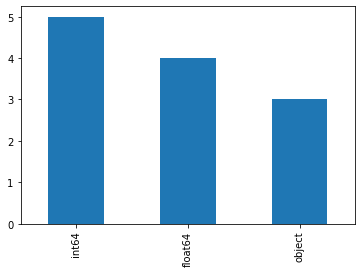

In [49]:
train.dtypes.value_counts().plot.bar()

In [50]:
train.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,PRICE
count,29050.000000,29050.000000,29050.000000,2.905000e+04,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000
mean,0.178967,0.315869,2.390809,2.003171e+04,0.821033,0.930361,21.270272,76.829585,141.712677
std,0.383332,0.464869,0.880677,1.914411e+06,0.383332,0.254541,6.195973,10.567572,650.055763
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000000e+02,1.000000,1.000000,18.452663,73.794800,38.000000
50%,0.000000,0.000000,2.000000,1.172742e+03,1.000000,1.000000,20.631532,77.322873,61.750000
75%,0.000000,1.000000,3.000000,1.550169e+03,1.000000,1.000000,26.886881,77.912934,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


In [51]:
train.isna().sum()

POSTED_BY             0
UNDER_CONSTRUCTION    0
RERA                  0
BHK_NO.               0
BHK_OR_RK             0
SQUARE_FT             0
READY_TO_MOVE         0
RESALE                0
ADDRESS               0
LONGITUDE             0
LATITUDE              0
PRICE                 0
dtype: int64

<AxesSubplot:>

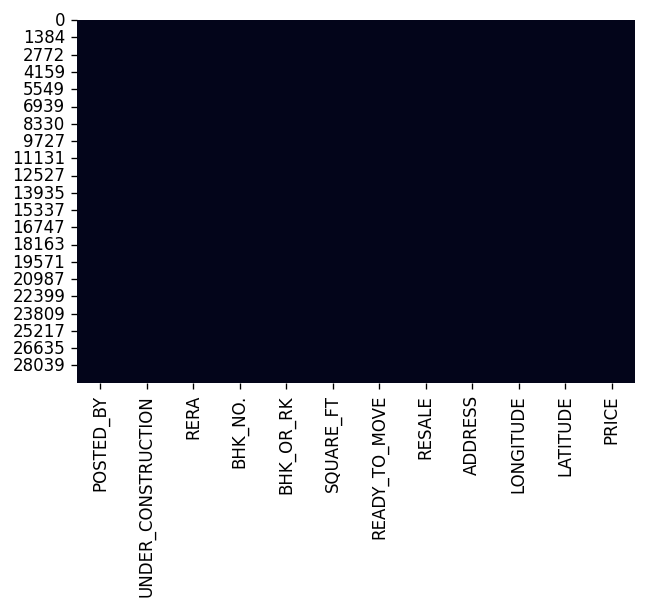

In [52]:
import matplotlib.pyplot as plt
plt.figure(dpi=120)
sns.heatmap(train.isna(),cbar=False)

In [53]:
# We will calculate the numbers of values for each column 
columns = train.columns
for col in columns:
    print(train[col].value_counts())
    print("the total values is :", train[col].value_counts().sum())
    print('*' * 50)

Dealer     17961
Owner      10470
Builder      619
Name: POSTED_BY, dtype: int64
the total values is : 29050
**************************************************
0    23851
1     5199
Name: UNDER_CONSTRUCTION, dtype: int64
the total values is : 29050
**************************************************
0    19874
1     9176
Name: RERA, dtype: int64
the total values is : 29050
**************************************************
2     13164
3     10365
1      3540
4      1698
5       189
6        52
7        11
8        10
20        4
10        4
15        4
12        3
9         3
13        1
17        1
11        1
Name: BHK_NO., dtype: int64
the total values is : 29050
**************************************************
BHK    29026
RK        24
Name: BHK_OR_RK, dtype: int64
the total values is : 29050
**************************************************
1000.000000    473
1250.000000    289
800.000000     198
1200.000000    178
1600.000000    124
              ... 
3224.128965      1
2400.04

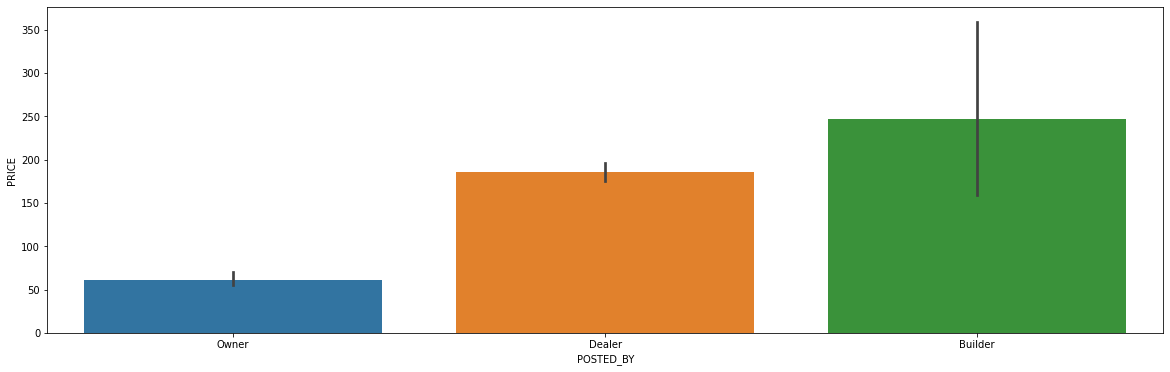

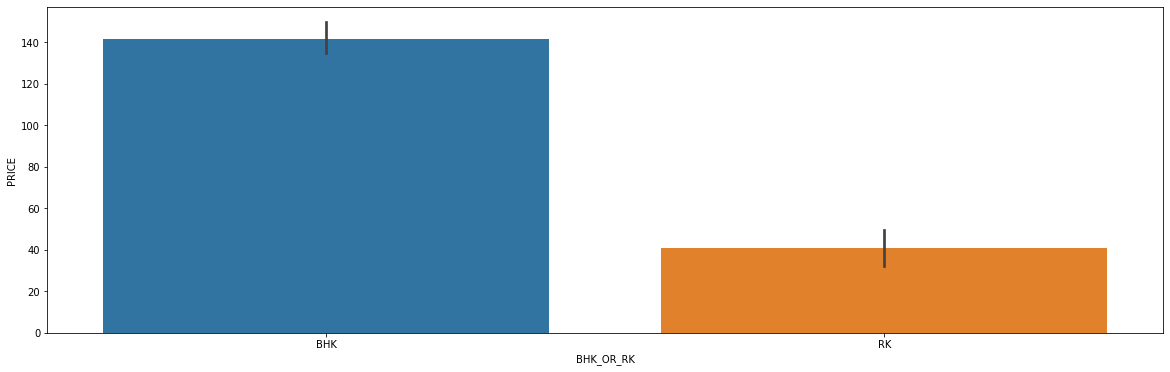

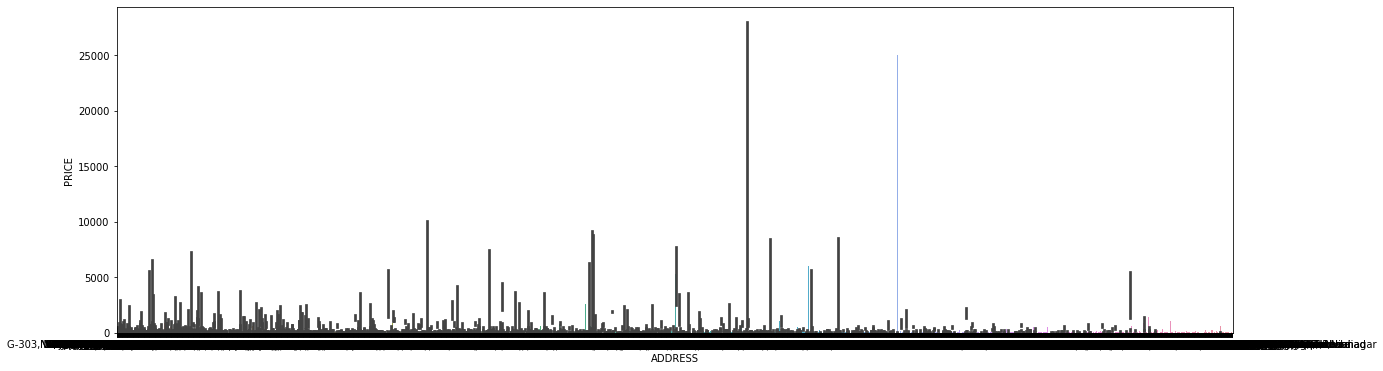

In [54]:
c_col = train.select_dtypes (object)
n_col = train.select_dtypes(['int', 'float'])

for col in c_col:
    plt.figure(figsize=(20,6))
    sns.barplot(x=train[col], y=train['PRICE'])

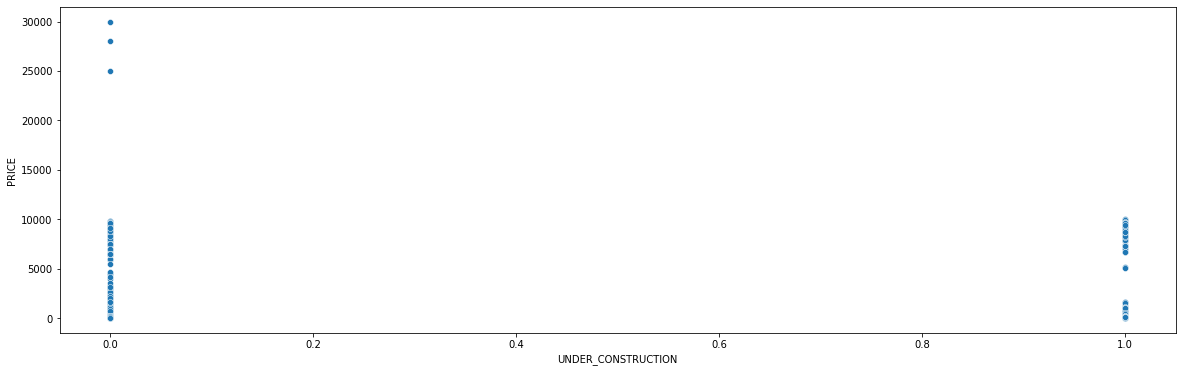

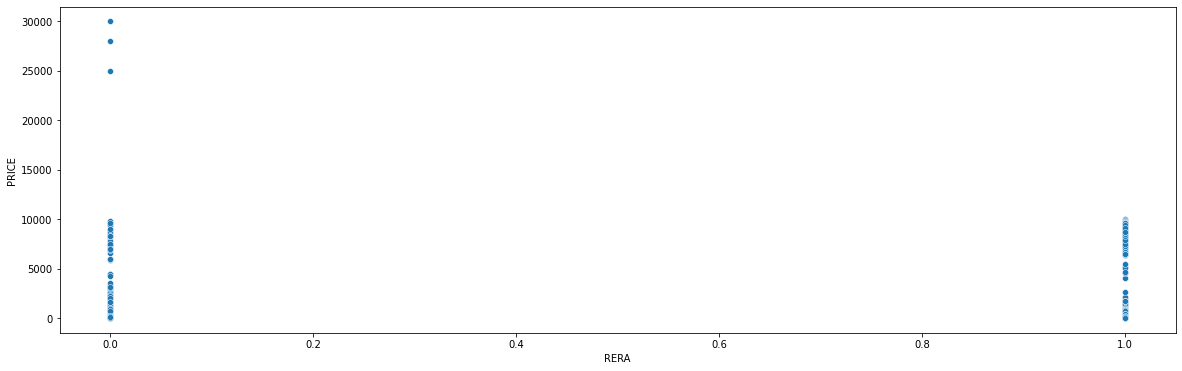

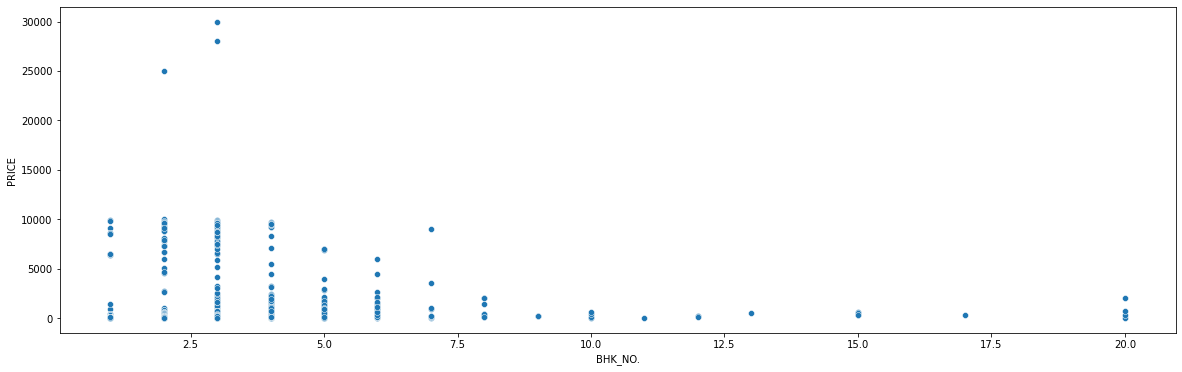

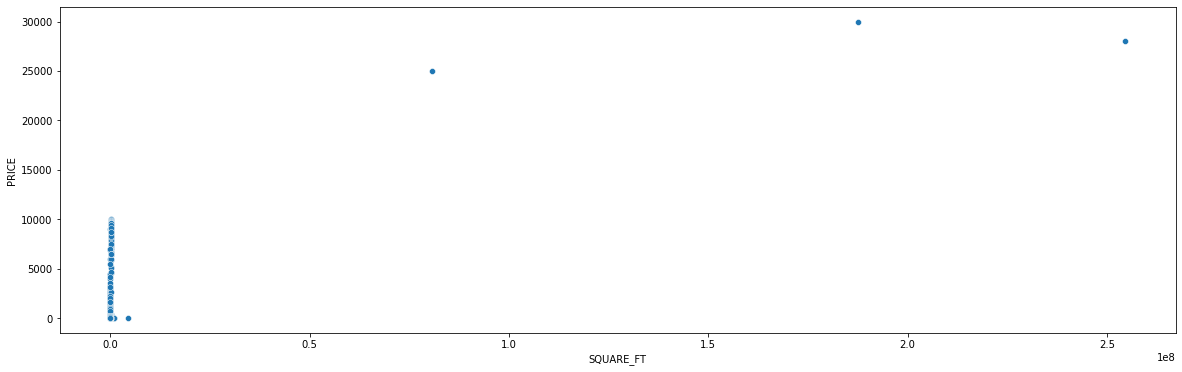

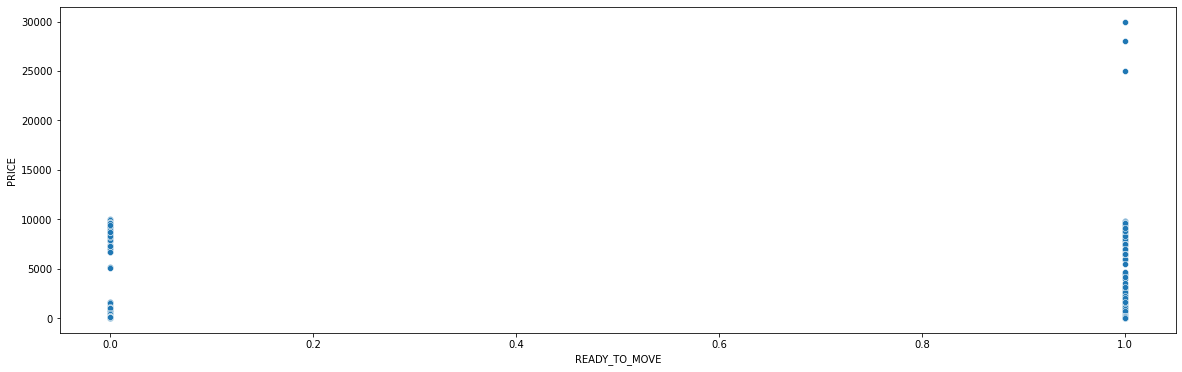

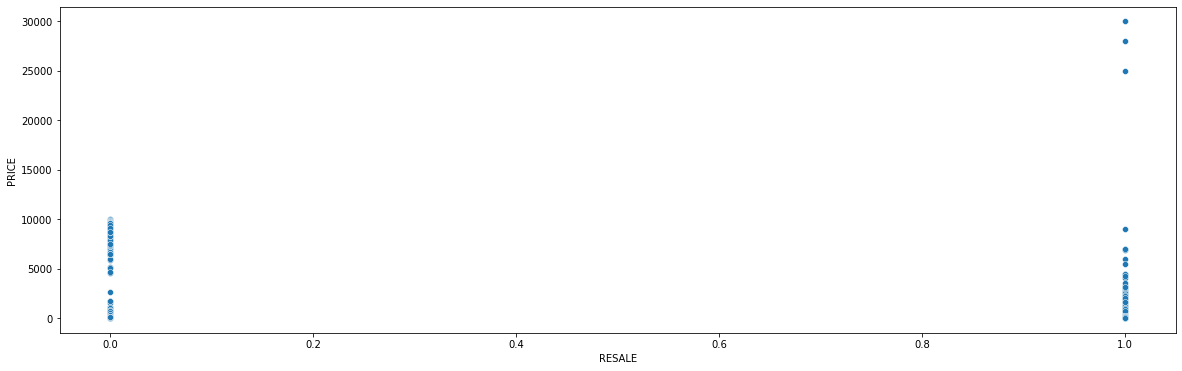

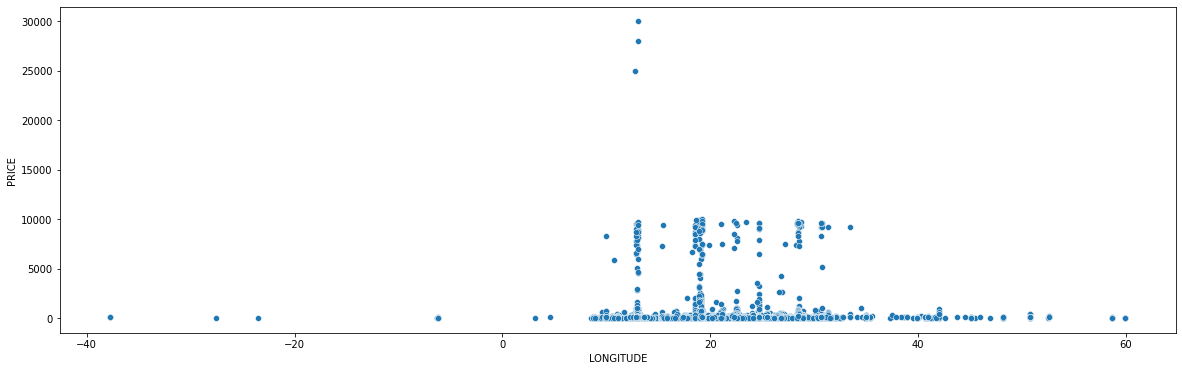

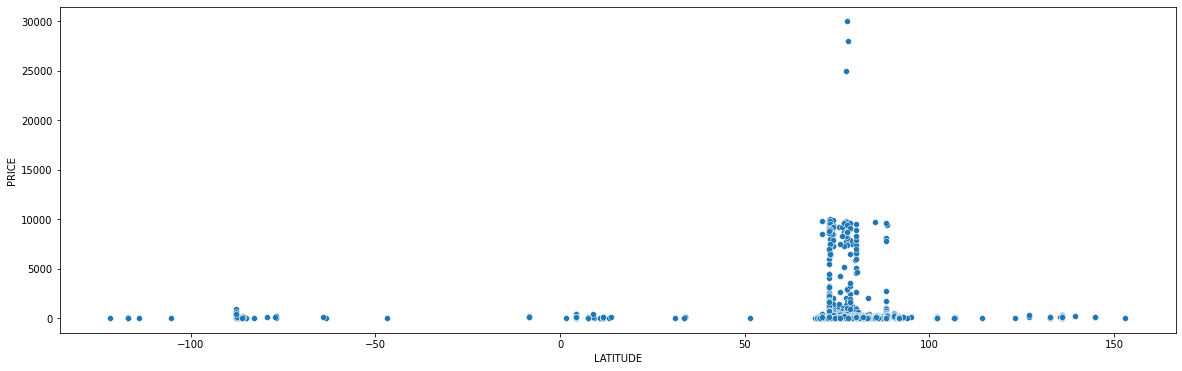

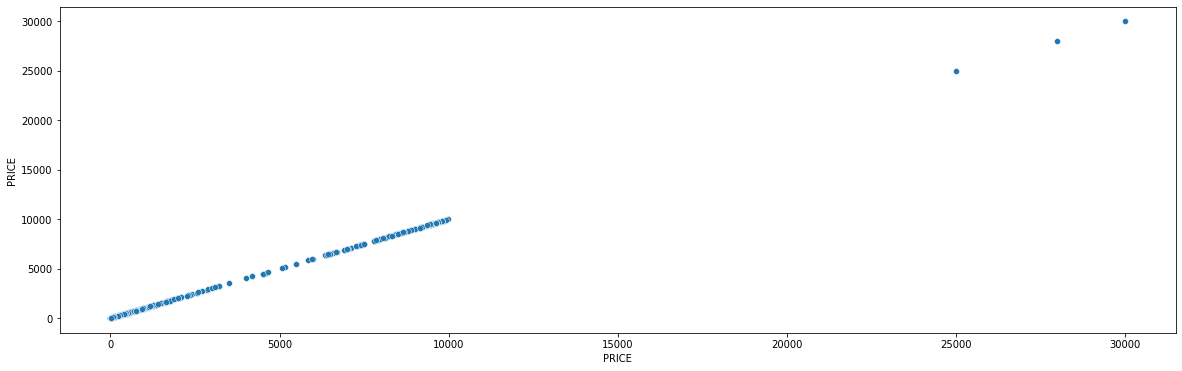

In [55]:
for col in n_col:
    plt.figure(figsize=(20,6))
    sns.scatterplot(x=train[col], y=train['PRICE'])

# one hot encoding

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate target from predictors
y = train.PRICE
X = train.drop(['PRICE'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

# Select categorical columns 
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [57]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['POSTED_BY', 'BHK_OR_RK']


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [59]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


30.35059729649104


# Pipeline 

In [60]:
# Separate target from predictors
y = train['PRICE']
X = train.drop(['PRICE'], axis=1)

# split the data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

# Categorical_col
#categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 
                    #and X_train_full[cname].dtype in ['object']]

# Numerical_col
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
categorical_cols = ['POSTED_BY', 'BHK_OR_RK']

my_cols = numerical_cols + categorical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [61]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [62]:
model = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)

In [63]:
# create the  pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('The mean absolute error is:', score) 

# Preprocessing of test data, fit model
preds_val = my_pipeline.predict(X_valid_full) 

The mean absolute error is: 29.95882504302926


In [65]:
output = pd.DataFrame({'Price': preds_val, 'real_price': y_valid})
output.head()

,Price,real_price
28441,212.000,200.0
6715,98.555,95.0
10106,53.929,55.3
7793,224.970,220.0
21130,63.054,56.0


In [77]:
# predict the Price value for the test data set 
preds_test = my_pipeline.predict(test) 

In [79]:
output_test = pd.DataFrame({'target price of house': preds_test})
output_test.head()

,target price of house
0,21.1455
1,65.3610
2,69.7270
3,40.5620
4,37.5990


In [81]:
output_test.shape

(68720, 1)

In [80]:
# we will save the prediction result to a csv file 
output_test.to_csv('sample_submission.csv')